In [ ]:
import os
import pandas as pd
import requests
from tqdm import tqdm
from google.colab import files, drive

In [ ]:
def get_pokemon_data(number):
    URL_SPECIES = f"https://pokeapi.co/api/v2/pokemon-species/{number}"
    URL_POKEMON = f"https://pokeapi.co/api/v2/pokemon/{number}"

    species_response = requests.get(URL_SPECIES)
    species_response.raise_for_status()
    species_data = species_response.json()

    pokemon_response = requests.get(URL_POKEMON)
    pokemon_response.raise_for_status()
    pokemon_data = pokemon_response.json()

    # FIELDS TO EXTRACT
    name = species_data['name']
    id = species_data['id']
    types = [t['type']['name'] for t in pokemon_data['types']]
    type_1 = types[0]
    type_2 = types[1] if len(types) > 1 else None
    generation = species_data['generation']['name']

    flavor_text_entries = species_data['flavor_text_entries']
    english_texts = []

    # gather all English flavor texts, process, and store if not duplicates
    for entry in flavor_text_entries:
        if entry['language']['name'] == 'en':
            txt = entry['flavor_text'].lower()
            txt = txt.replace('\n', ' ')
            txt = txt.replace('é', 'e')
            english_texts.append(txt)

    # remove duplicates, then combine
    english_texts = list(set(english_texts))
    combined_entry = " ".join(english_texts)

    return {
        "id": id,
        "name": name,
        "type1": type_1,
        "type2": type_2,
        "gen": generation,
        "entry": combined_entry
    }

In [ ]:
NUM_POKEMON = 1025

TYPE_COLORS = {
    'normal': '#9FA19F',
    'fire': '#E72829',
    'water': '#2980EF',
    'electric': '#FAC100',
    'grass': '#3FA129',
    'ice': '#3CCEF2',
    'fighting': '#FF8001',
    'poison': '#9141CB',
    'ground': '#915120',
    'flying': '#81B9EF',
    'psychic': '#EE4179',
    'bug': '#91A019',
    'rock': '#AFA981',
    'ghost': '#704271',
    'dragon': '#5061E1',
    'dark': '#624D4F',
    'steel': '#5FA2B9',
    'fairy': '#EF70EF'
}

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/pokedex.csv'

if os.path.exists(file_path):
    print(f"File already exists: {file_path}")
    df = pd.read_csv(file_path)
else:
    print("File not found. Fetching data...")
    pokemon_data_list = []
    for i in tqdm(range(1, NUM_POKEMON + 1), desc="Fetching Pokémon Data"):
        data = get_pokemon_data(i)
        if data:
            pokemon_data_list.append(data)
    df = pd.DataFrame(pokemon_data_list)
    print(f"Number of Pokémon processed: {len(df)}")

    print(f"Cleaning dataset.")
    ####### CLEANING #######
    df['entry'] = df['entry'].fillna('')  # Replace NaNs with empty strings
    df['entry'] = df['entry'].str.replace('\n', ' ', regex=False)
    df['entry'] = df['entry'].str.replace('é', 'e', regex=False)

    df['entry'] = df['entry'].replace(to_replace="[''-]", value=' ', regex=True)  # Separate possessives
    df['entry'] = df['entry'].replace(to_replace=r'[^a-zA-Z0-9 ]', value='', regex=True)  # Remove punctuation
    df['entry'] = df['entry'].replace(to_replace=[n.lower() for n in df['name'].values], value='', regex=True)  # Remove Pokémon names
    df['entry'] = df['entry'].replace(to_replace='pokemon', value='', regex=True)  # Remove the word "Pokemon"
    df['entry'] = df['entry'].replace(to_replace='[0-9]+', value='#', regex=True)  # Replace numbers with #
    df['entry'] = df['entry'].replace(to_replace=r'\s+', value=' ', regex=True)  # Remove extra spaces
    df['entry'] = df['entry'].str.lower()
    ########################
    df.to_csv(file_path, index=False)
    print(f"Data saved to: {file_path}")

Mounted at /content/drive
File already exists: /content/drive/My Drive/pokedex.csv


# Data

The dataset is sourced from the PokéAPI, a free API that provides comprehensive data on Pokémon. It includes detailed information about each of the 1,025 Pokémon, such as their names, types, generation, and Pokedex entries.

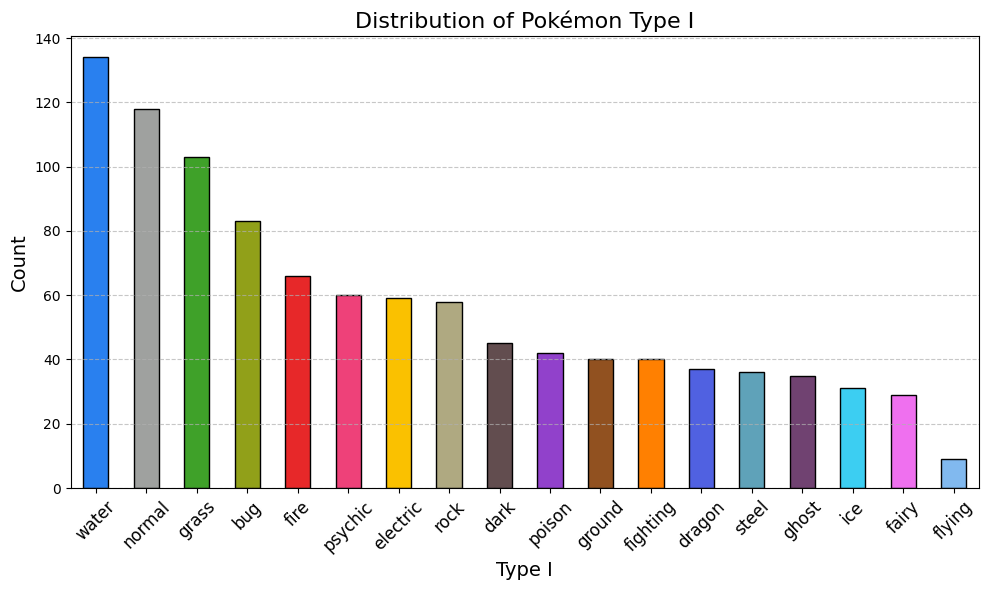

In [ ]:
import matplotlib.pyplot as plt

type_counts = df['type1'].value_counts()
bar_colors = [TYPE_COLORS[ptype.lower()] for ptype in type_counts.index]

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Distribution of Pokémon Type I', fontsize=16)
plt.xlabel('Type I', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

We can see that flying is significantly underrepresented. Pokemon fans can recognize that this is because there is a significant number of pokemon that are Normal/Flying. We can balance this out by taking Normal/Flying pokemon and listing them as Flying/Normal instead.

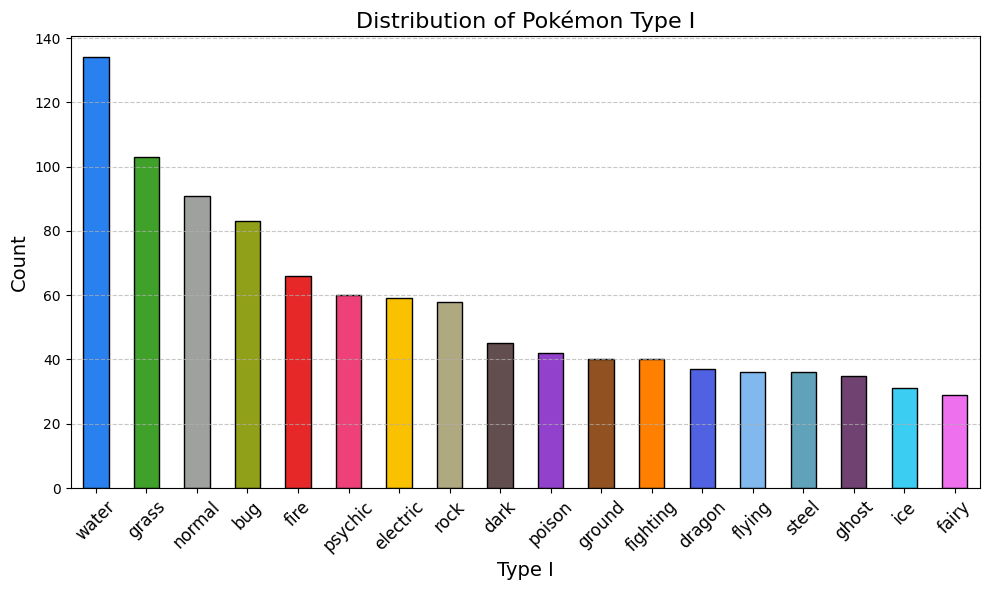

In [ ]:
df.loc[(df['type1']=='normal') & (df['type2']=='flying'), ['type1','type2']] = ['flying', 'normal']

type_counts = df['type1'].value_counts()
bar_colors = [TYPE_COLORS[ptype.lower()] for ptype in type_counts.index]

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=bar_colors, edgecolor='black')
plt.title('Distribution of Pokémon Type I', fontsize=16)
plt.xlabel('Type I', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [ ]:
entry_lengths = df['entry'].astype(str).apply(lambda x: len(x.split()))

stats = entry_lengths.describe(percentiles=[0.25, 0.5, 0.75])
iqr = stats['75%'] - stats['25%']

print(f"Mean length: {stats['mean']:.2f} words")
print(f"Min length: {stats['min']} words")
print(f"Max length: {stats['max']} words")
print(f"Median length: {stats['50%']} words")
print(f"IQR (Interquartile Range): {iqr} words")
print(f"25th percentile: {stats['25%']} words")
print(f"75th percentile: {stats['75%']} words")

num_short_entries = (df['entry'].astype(str).apply(lambda x: len(x.split())) < 50).sum()
print(f"Number of Pokémon with fewer than 100 words in their entry: {num_short_entries}")

Mean length: 174.95 words
Min length: 20.0 words
Max length: 569.0 words
Median length: 133.0 words
IQR (Interquartile Range): 209.0 words
25th percentile: 56.0 words
75th percentile: 265.0 words
Number of Pokémon with fewer than 100 words in their entry: 223


In [ ]:
df.head()

,id,name,type1,type2,gen,entry
0,1,bulbasaur,grass,poison,generation-i,for some time after its birth it grows by gain...
1,2,ivysaur,grass,poison,generation-i,to support its bulb s legs grow sturdy if it s...
2,3,venusaur,grass,poison,generation-i,there is a large flower on s back the flower i...
3,4,charmander,fire,NaN,generation-i,the flame that burns at the tip of its tail is...
4,5,charmeleon,fire,NaN,generation-i,without pity its sharp claws destroy foes if i...


# One-Hot Encoding

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import plotly.express as px

stop_words = set(stopwords.words('english'))
df['tokens'] = df['entry'].apply(lambda x: [
    w.lower() for w in word_tokenize(str(x))
    if w.isalpha() and w.lower() not in stop_words
])

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
df['tokens'] = df['tokens'].apply(lambda toks: [stemmer.stem(t) for t in toks])

vocab = set()
for tlist in df['tokens']:
    vocab.update(tlist)
vocab = list(vocab)
token_to_idx = {t: i for i, t in enumerate(vocab)}

def one_hot_encode(tokens):
    vec = [0]*len(token_to_idx)
    for tok in tokens:
        vec[token_to_idx[tok]] = 1
    return vec

df['one_hot'] = df['tokens'].apply(one_hot_encode)

le = LabelEncoder()
df['label'] = le.fit_transform(df['type1'])

X = np.array(df['one_hot'].tolist())
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_train_res, y_train_res)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print("Accuracy:", acc)

# t-SNE Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

df_tsne = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'name': df['name'],
    'entry': df['entry'],
    'type1': df['type1']
})

df_tsne['entry_short'] = df_tsne['entry'].apply(
    lambda txt: (txt[:100] + "...") if len(txt) > 100 else txt
)

fig = px.scatter(
    df_tsne,
    x='x',
    y='y',
    color='type1',
    hover_data=['name', 'entry_short'],
    title="t-SNE of Pokémon (Hover for details)",
    color_discrete_map=TYPE_COLORS
)

fig.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Accuracy: 0.48292682926829267


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, preds, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

         bug       0.47      0.41      0.44        17
        dark       0.17      0.11      0.13         9
      dragon       0.00      0.00      0.00         7
    electric       0.82      0.75      0.78        12
       fairy       0.20      0.17      0.18         6
    fighting       0.44      0.50      0.47         8
        fire       0.71      0.92      0.80        13
      flying       0.00      0.00      0.00         7
       ghost       1.00      0.43      0.60         7
       grass       0.50      0.57      0.53        21
      ground       0.60      0.38      0.46         8
         ice       0.67      0.33      0.44         6
      normal       0.38      0.56      0.45        18
      poison       0.60      0.38      0.46         8
     psychic       0.44      0.58      0.50        12
        rock       0.36      0.33      0.35        12
       steel       0.29      0.29      0.29         7
       water       0.59    

# TF-IDF

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

df_tf_idf = df

df_tf_idf['entry'] = df_tf_idf['entry'].fillna('')

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
tfidf_matrix = vectorizer.fit_transform(df_tf_idf['entry'])

feature_names = np.array(vectorizer.get_feature_names_out())

top_n = 5  # Number of important words to extract per Pokemon
important_words = []

for i, name in enumerate(df_tf_idf['name']):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = row.argsort()[-top_n:][::-1]
    top_words = feature_names[top_indices]
    important_words.append(", ".join(top_words))

df_tf_idf['important_words'] = important_words

In [ ]:
df_tf_idf.head()

,id,name,type1,type2,gen,entry,tokens,one_hot,label,glove_vec,important_words
0,1,bulbasaur,grass,poison,generation-i,for some time after its birth it grows by gain...,"[time, birth, grow, gain, nourish, seed, back,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,"[-0.1732616, 0.485845, 0.21300209, -0.13182285...","seed, grows, larger, birth, plant"
1,2,ivysaur,grass,poison,generation-i,to support its bulb s legs grow sturdy if it s...,"[support, bulb, leg, grow, sturdi, spend, time...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,"[-0.17666015, 0.44959426, 0.01417807, -0.28761...","bud, bulb, bloom, flower, large"
2,3,venusaur,grass,poison,generation-i,there is a large flower on s back the flower i...,"[larg, flower, back, flower, said, take, vivid...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,"[-0.21774791, 0.38928774, -0.06196205, -0.1955...","flower, sunlight, aroma, rays, soothes"
3,4,charmander,fire,NaN,generation-i,the flame that burns at the tip of its tail is...,"[flame, burn, tip, tail, indic, emot, flame, w...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,"[-0.33964077, 0.13946252, 0.07004543, -0.41083...","flame, burns, tail, tip, healthy"
4,5,charmeleon,fire,NaN,generation-i,without pity its sharp claws destroy foes if i...,"[without, piti, sharp, claw, destroy, foe, enc...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",6,"[-0.27547014, 0.1279519, 0.11746136, -0.284679...","bluish, tail, white, claws, unbearably"


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

## Training on TF-IDF Important Words

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_tf_idf['type1'])

X_train, X_test, y_train, y_test = train_test_split(df_tf_idf['important_words'], y, test_size=0.2, random_state=42)

svm_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('svm', SVC(kernel='linear', probability=True))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(report)

              precision    recall  f1-score   support

         bug       0.33      0.47      0.39        17
        dark       0.00      0.00      0.00        10
      dragon       1.00      0.17      0.29         6
    electric       0.56      0.45      0.50        11
       fairy       0.50      0.17      0.25         6
    fighting       0.50      0.22      0.31         9
        fire       0.50      0.56      0.53         9
      flying       0.00      0.00      0.00         4
       ghost       0.00      0.00      0.00         9
       grass       0.32      0.50      0.39        22
      ground       0.67      0.17      0.27        12
         ice       0.33      0.50      0.40         4
      normal       0.17      0.29      0.22        17
      poison       0.75      0.27      0.40        11
     psychic       0.40      0.15      0.22        13
        rock       0.36      0.40      0.38        10
       steel       1.00      0.12      0.22         8
       water       0.28    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Training on Regular Pokedex Entry Text

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_tf_idf['type1'])

X_train, X_test, y_train, y_test = train_test_split(df_tf_idf['entry'], y, test_size=0.2, random_state=42)

svm_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('svm', SVC(kernel='linear', probability=True))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(report)


              precision    recall  f1-score   support

         bug       0.50      0.47      0.48        17
        dark       1.00      0.10      0.18        10
      dragon       0.00      0.00      0.00         6
    electric       0.67      0.73      0.70        11
       fairy       0.00      0.00      0.00         6
    fighting       0.67      0.44      0.53         9
        fire       0.80      0.89      0.84         9
      flying       0.00      0.00      0.00         4
       ghost       0.00      0.00      0.00         9
       grass       0.41      0.73      0.52        22
      ground       0.75      0.25      0.38        12
         ice       0.75      0.75      0.75         4
      normal       0.32      0.65      0.43        17
      poison       0.83      0.45      0.59        11
     psychic       0.40      0.31      0.35        13
        rock       0.31      0.40      0.35        10
       steel       0.00      0.00      0.00         8
       water       0.45    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# GLOVE

In [ ]:
import os
import requests
import zipfile
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

nltk.download('punkt')
nltk.download('stopwords')

GLOVE_PATH = 'glove.6B.100d.txt'
if not os.path.exists(GLOVE_PATH):
    print("Downloading GloVe 100d vectors...")
    glove_zip_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(glove_zip_url)
    with open('glove.6B.zip', 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile('glove.6B.zip', 'r') as z:
        z.extractall('.')  # extracts glove.6B.100d.txt, glove.6B.50d.txt, etc.
    os.remove('glove.6B.zip')

print("Loading GloVe into memory...")
embeddings_index = {}
with open(GLOVE_PATH, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Done loading GloVe.")

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def tokenize_and_clean(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [stemmer.stem(t) for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df['tokens'] = df['entry'].apply(tokenize_and_clean)

def text_to_glove_vector(tokens):
    # for each token, retrieve GloVe vector if available.
    # then average them to get a single vector per entry.
    vectors = []
    for t in tokens:
        if t in embeddings_index:
            vectors.append(embeddings_index[t])
    if len(vectors) == 0:
        return np.zeros(100, dtype='float32')
    else:
        return np.mean(vectors, axis=0)

df['glove_vec'] = df['tokens'].apply(text_to_glove_vector)

X_glove = np.vstack(df['glove_vec'].values)
le = LabelEncoder()
df['label'] = le.fit_transform(df['type1'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_glove, y, test_size=0.2, random_state=42, stratify=y
)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

model = BernoulliNB()
model.fit(X_train_res > 0, y_train_res)
y_pred = model.predict(X_test > 0)
acc = accuracy_score(y_test, y_pred)
print("BernoulliNB (binary embeddings) Accuracy:", acc)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_glove)

# plt.figure(figsize=(10,7))
# for i, ctype in enumerate(le.classes_):
#     idx = (y == i)
#     color = TYPE_COLORS.get(ctype, 'black')
#     plt.scatter(X_embedded[idx,0], X_embedded[idx,1], label=ctype, color=color, alpha=0.6)
# plt.title("t-SNE of GloVe Embeddings")
# plt.legend()
# plt.show()

df_tsne = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'name': df['name'],
    'entry': df['entry'],
    'type1': df['type1']
})

df_tsne['entry_short'] = df_tsne['entry'].apply(
    lambda txt: (txt[:100] + "...") if len(txt) > 100 else txt
)

fig = px.scatter(
    df_tsne,
    x='x',
    y='y',
    color='type1',
    hover_data=['name', 'entry_short'],
    title="t-SNE of Pokémon (Hover for details)",
    color_discrete_map=TYPE_COLORS
)

fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading GloVe into memory...
Done loading GloVe.
BernoulliNB (binary embeddings) Accuracy: 0.3170731707317073


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

         bug       0.43      0.18      0.25        17
        dark       0.00      0.00      0.00         9
      dragon       0.00      0.00      0.00         7
    electric       0.40      0.33      0.36        12
       fairy       0.00      0.00      0.00         6
    fighting       0.29      0.75      0.41         8
        fire       0.47      0.54      0.50        13
      flying       0.00      0.00      0.00         7
       ghost       0.19      0.43      0.26         7
       grass       0.60      0.29      0.39        21
      ground       0.20      0.25      0.22         8
         ice       0.44      0.67      0.53         6
      normal       0.36      0.22      0.28        18
      poison       0.36      0.62      0.45         8
     psychic       0.27      0.33      0.30        12
        rock       0.33      0.33      0.33        12
       steel       0.10      0.14      0.12         7
       water       0.57    

# BERT

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from transformers import (BertTokenizer, BertForSequenceClassification, Trainer,
                          TrainingArguments, EarlyStoppingCallback)

In [ ]:
types = sorted(df['type1'].unique())
type2id = {t: i for i, t in enumerate(types)}
df['label'] = df['type1'].apply(lambda x: type2id[x])
min_count = df['gen'].value_counts().min()
val_count_per_gen = int(min_count * 0.2)

val_df = df.groupby('gen', group_keys=False).apply(
    lambda x: x.sample(n=val_count_per_gen, random_state=42)
).reset_index(drop=True)

train_df = df.drop(val_df.index).reset_index(drop=True)

# we oversample the training set to balance type imbalances
ros = RandomOverSampler(random_state=42)
train_df_balanced, _ = ros.fit_resample(train_df, train_df['type1'])

<ipython-input-41-0d94162d9a17>:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
class PokeDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df['entry'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = PokeDataset(train_df_balanced, tokenizer)
val_dataset = PokeDataset(val_df, tokenizer)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(types))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {'accuracy': accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



In [ ]:
trainer.train()
results = trainer.evaluate()
print("Validation Accuracy:", results['eval_accuracy'])

Epoch,Training Loss,Validation Loss,Accuracy
1,1.780800,1.553652,0.595238
2,0.665700,0.558131,0.920635
3,0.275000,0.337535,0.920635
4,0.097700,0.314456,0.944444
5,0.031800,0.285470,0.952381
6,0.006900,0.283128,0.952381
7,0.004700,0.308470,0.944444


Validation Accuracy: 0.9523809523809523


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

report = classification_report(true_labels, preds, target_names=types)
print(report)

              precision    recall  f1-score   support

         bug       0.88      0.78      0.82         9
        dark       1.00      1.00      1.00         7
      dragon       1.00      1.00      1.00         3
    electric       1.00      0.86      0.92         7
       fairy       1.00      1.00      1.00         2
    fighting       1.00      0.88      0.93         8
        fire       1.00      1.00      1.00        10
      flying       1.00      0.75      0.86         4
       ghost       1.00      1.00      1.00         2
       grass       0.83      1.00      0.91        15
      ground       1.00      1.00      1.00         2
         ice       0.83      1.00      0.91         5
      normal       1.00      1.00      1.00        18
      poison       1.00      1.00      1.00         5
     psychic       1.00      1.00      1.00         7
        rock       1.00      1.00      1.00         8
       steel       0.75      1.00      0.86         3
       water       1.00    

In [ ]:
model_save_path = '/content/drive/My Drive/pokemon_bert_best_model'
model.save_pretrained(model_save_path)
print("Model saved to", model_save_path)

Model saved to /content/drive/My Drive/pokemon_bert_best_model


In [ ]:
# LOAD THE MODEL IF ALREADY TRAINED

# model_save_path = '/content/drive/My Drive/pokemon_bert_best_model'
# model = BertForSequenceClassification.from_pretrained(model_save_path)
# print("Model loaded from", model_save_path)

Model loaded from /content/drive/My Drive/pokemon_bert_best_model


In [ ]:
def extract_bert_embeddings(dataset, model):
    model.eval()
    embeddings = []

    device = next(model.parameters()).device

    with torch.no_grad():
        for i in range(len(dataset)):
            item = dataset[i]
            # get the input_ids and attention_mask from the dataset item, send them to the same device as the model
            input_ids = item['input_ids'].unsqueeze(0).to(device)
            attention_mask = item['attention_mask'].unsqueeze(0).to(device)

            output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)

    return np.vstack(embeddings)

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
import pandas as pd
import torch

unique_train_df = train_df_balanced.drop_duplicates(subset='id').reset_index(drop=True)
unique_train_dataset = PokeDataset(unique_train_df, tokenizer)

X_bert = extract_bert_embeddings(unique_train_dataset, model)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_bert)

df_tsne = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'name': unique_train_df['name'].values,
    'entry': unique_train_df['entry'].values,
    'type1': unique_train_df['type1'].values
})

df_tsne['entry_short'] = df_tsne['entry'].apply(
    lambda txt: (txt[:100] + "...") if len(txt) > 100 else txt
)

fig = px.scatter(
    df_tsne,
    x='x',
    y='y',
    color='type1',
    hover_data=['name', 'entry_short'],
    title="t-SNE of Pokémon (BERT Embeddings, Hover for details)",
    color_discrete_map=TYPE_COLORS
)

fig.show()

In [ ]:
def classify_txt(sentence):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        sentence,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    pred_idx = outputs.logits.argmax(dim=-1).item()
    id2type = {v: k for k, v in type2id.items()}

    return id2type[pred_idx]

In [ ]:
# Harry Potter
txt = "A brave and resourceful wizard, he wields immense magical power, protected by love and bound by destiny to face the Dark Lord.."
predicted_type = classify_txt(txt)
print("Predicted Pokémon type:", predicted_type)

Predicted Pokémon type: psychic


In [ ]:
# The Little Mermaid
txt = "A curious and adventurous mermaid, Ariel’s shimmering scales and hypnotic voice conceal a relentless desire for discovery, defying the depths to chase the mysteries of the surface world."
predicted_type = classify_txt(txt)
print("Predicted Pokémon type:", predicted_type)

Predicted Pokémon type: water


# BiLSTM for dual-type classification

In [ ]:
# Assumes pokedex.csv is in google drive
from google.colab import files, drive

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/pokedex.csv'

if os.path.exists(file_path):
    print(f"File already exists: {file_path}")
    df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File already exists: /content/drive/My Drive/pokedex.csv


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from imblearn.over_sampling import RandomOverSampler

NUM_CLASSES = 18

# Switch flying and normal
df.loc[(df['type1']=='normal') & (df['type2']=='flying'), ['type1','type2']] = ['flying', 'normal']

types = sorted(df['type1'].unique())
type2id = {t: i for i, t in enumerate(types)}
df['label1'] = df['type1'].apply(lambda x: type2id[x])
df['label2'] = df['type2'].apply(lambda x: type2id[x] if pd.notna(x) else -1)
min_count = df['gen'].value_counts().min()
val_count_per_gen = int(min_count * 0.2)

val_df = df.groupby('gen', group_keys=False).apply(
    lambda x: x.sample(n=val_count_per_gen, random_state=42)
).reset_index(drop=True)

train_df = df.drop(val_df.index).reset_index(drop=True)

# we oversample the training set to balance type imbalances
ros = RandomOverSampler(random_state=42)
train_df_balanced, _ = ros.fit_resample(train_df, train_df['type1'])

<ipython-input-11-00744fb16ce1>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = df.groupby('gen', group_keys=False).apply(


In [ ]:
# Sanity checks
print(train_df_balanced['type1'].value_counts())
print(val_df['type1'].value_counts())
print(train_df_balanced['type2'].value_counts())
print(val_df['type2'].value_counts())
print(train_df_balanced.head())
print(val_df.head())

type1
bug         110
normal      110
water       110
electric    110
fire        110
rock        110
ice         110
dragon      110
psychic     110
grass       110
flying      110
poison      110
fairy       110
dark        110
ghost       110
ground      110
steel       110
fighting    110
Name: count, dtype: int64
type1
normal      18
grass       15
water       11
fire        10
bug          9
fighting     8
rock         8
dark         7
psychic      7
electric     7
ice          5
poison       5
flying       4
dragon       3
steel        3
ground       2
ghost        2
fairy        2
Name: count, dtype: int64
type2
flying      156
normal      119
psychic      82
dragon       79
ghost        77
fighting     69
ground       64
steel        60
fairy        60
dark         57
water        51
grass        50
fire         41
poison       40
rock         30
ice          27
bug          21
electric     19
Name: count, dtype: int64
type2
flying      7
ghost       7
normal      6
dragon    

In [ ]:
NUM_CLASSES = 18 # number of Pokemon types

def encode_labels(df):
    """
    Create one-hot encoded labels for type1 and type2.
    """
    labels = torch.zeros((len(df), NUM_CLASSES), dtype=torch.float32)

    for idx, row in df.iterrows():
        labels[idx, row['label1']] = 1
        if row['label2'] != -1:  # Check if type2 exists
            labels[idx, row['label2']] = 1

    return labels

In [ ]:
from torch.utils.data import Dataset

class PokemonDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        """
        Args:
            df (pd.DataFrame): DataFrame with 'text', 'type1', 'type2' columns.
            tokenizer (Tokenizer): Tokenizer for text processing.
            max_len (int): Max token length for padding/truncation.
        """
        self.texts = df['entry'].tolist()
        self.labels = encode_labels(df)  # Convert type1/type2 to one-hot encoding
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label
        }

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3

train_dataset = PokemonDataset(train_df_balanced, tokenizer, MAX_LEN)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Example batch:
batch = next(iter(train_loader))
print("Input IDs:", batch['input_ids'].shape)
print("Labels:", batch['label'].shape)  # shape is (batch_size, NUM_CLASSES)

Input IDs: torch.Size([32, 128])
Labels: torch.Size([32, 18])


In [ ]:
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, device):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # 18 probs: one per class
        self.device = device

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids.to(self.device))
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take last timestep output
        logits = self.fc(lstm_out)
        return logits  # No sigmoid here (handled by loss function)

In [ ]:
bilstm_model = BiLSTMClassifier(vocab_size=len(tokenizer.vocab), embed_dim=768,
                         hidden_dim=256, num_classes=NUM_CLASSES, device=device).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    bilstm_model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = bilstm_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.3118
Epoch 2/10, Loss: 0.2602
Epoch 3/10, Loss: 0.2096
Epoch 4/10, Loss: 0.1713
Epoch 5/10, Loss: 0.1437
Epoch 6/10, Loss: 0.1222
Epoch 7/10, Loss: 0.1004
Epoch 8/10, Loss: 0.0789
Epoch 9/10, Loss: 0.0598
Epoch 10/10, Loss: 0.0446


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def evaluate(model, val_loader, device):
    """
    Evaluate the model on the validation dataset.

    Args:
        model (nn.Module): Trained model.
        val_loader (DataLoader): Validation dataset loader.
        device (torch.device): CPU/GPU device.

    Returns:
        avg_loss (float): Average validation loss.
        accuracy (float): Multilabel accuracy.
        f1 (float): F1-score.
    """
    bilstm_model.eval()  # Set to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = bilstm_model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Convert logits to probabilities
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.25).int()  # Threshold at 0.25

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Compute accuracy and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # Macro F1-score for multilabel

    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy, f1


val_dataset = PokemonDataset(val_df, tokenizer, MAX_LEN)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_loss, val_acc, val_f1 = evaluate(bilstm_model, val_loader, device)

print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")

Val Loss: 0.0707, Accuracy: 0.8492, F1-score: 0.9036


In [ ]:
# Code for predicting new examples

id2type = {i: t for t, i in type2id.items()} # map back to type names

def predict_pokemon_type(model, text, tokenizer, device):
    """
    Predict Pokémon type(s) from a given text description.

    Args:
        model (nn.Module): Trained BiLSTM model.
        text (str): Pokémon description.
        tokenizer (Tokenizer): Tokenizer used for text preprocessing.
        device (torch.device): CPU/GPU device.

    Returns:
        predicted_types (list): List of predicted Pokémon type indices.
    """
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits)  # Convert to probability
        predicted_labels = (probs > 0.25).int()  # Threshold to get binary predictions

    predicted_types = torch.where(predicted_labels[0] == 1)[0].tolist()  # Extract type indices
    result = []
    for i in predicted_types:
        result.append(id2type[i])
    return result

In [ ]:
# Batman
example = "Shrouded in darkness, Batman silently patrols the night, striking fear into criminals with his unmatched intellect and combat skills. Though he has no superpowers, his mastery of strategy and gadgets makes him a formidable opponent."
predict_pokemon_type(bilstm_model, example, tokenizer, device)

['fighting', 'poison']

In [ ]:
# Godzilla
example = "A towering behemoth, it awakens in times of great peril. Its devastating roar can level cities, and its atomic breath scorches everything in its path."
predict_pokemon_type(bilstm_model, example, tokenizer, device)

['dragon']

# BERT for Dual-Type

## BERT No Oversampling

### Setup

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn as nn

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['types'])

texts = df['entry'].fillna('').tolist()
names = df['name'].tolist()

train_texts, test_texts, train_labels, test_labels, train_names, test_names = train_test_split(
    texts, Y, names, test_size=0.2, random_state=42
)

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

class PokemonDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

train_dataset = PokemonDataset(train_texts, train_labels, tokenizer)
test_dataset  = PokemonDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

num_types = len(mlb.classes_)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_types,
    problem_type="multi_label_classification"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_labels_array = np.array(train_labels)
class_counts = np.sum(train_labels_array, axis=0)
class_counts[class_counts == 0] = 1
total_samples = len(train_labels)
class_weights = total_samples / (num_types * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - avg train loss: {avg_loss:.4f}")

model.eval()
all_preds = []
all_true = []
all_probs = []
threshold = 0.3

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))
        all_probs.append(probs)

        batch_preds = []
        for sample_prob in probs:
            idxs = np.where(sample_prob >= threshold)[0]
            if len(idxs) > 2:
                sorted_idxs = idxs[np.argsort(sample_prob[idxs])[::-1]]
                idxs = sorted_idxs[:2]
            if len(idxs) == 0:
                idxs = np.array([np.argmax(sample_prob)])
            pred_vector = np.zeros_like(sample_prob, dtype=int)
            pred_vector[idxs] = 1
            batch_preds.append(pred_vector)
        batch_preds = np.vstack(batch_preds)
        all_preds.append(batch_preds)
        all_true.append(labels)

all_preds = np.vstack(all_preds)
all_true  = np.vstack(all_true)
all_probs = np.vstack(all_probs)

predicted_types = mlb.inverse_transform(all_preds)
true_types = mlb.inverse_transform(all_true)

print("\nSample Predictions:")
for i in range(10):
    print(f"Name: {test_names[i]} | Predicted types: {predicted_types[i]} | True types: {true_types[i]}")

avg_probs = np.mean(all_probs, axis=0)
print("\nAverage predicted probabilities per label:")
print({label: avg for label, avg in zip(mlb.classes_, avg_probs)})

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=mlb.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - avg train loss: 0.2645
Epoch 2 - avg train loss: 0.1954
Epoch 3 - avg train loss: 0.1838
Epoch 4 - avg train loss: 0.1658
Epoch 5 - avg train loss: 0.1468
Epoch 6 - avg train loss: 0.1272
Epoch 7 - avg train loss: 0.1093
Epoch 8 - avg train loss: 0.0950
Epoch 9 - avg train loss: 0.0816
Epoch 10 - avg train loss: 0.0702

Sample Predictions:
Name: swoobat | Predicted types: ('dragon',) | True types: ('flying', 'psychic')
Name: wynaut | Predicted types: ('fighting',) | True types: ('psychic',)
Name: lucario | Predicted types: ('psychic',) | True types: ('fighting', 'steel')
Name: nidoran-m | Predicted types: ('poison',) | True types: ('poison',)
Name: golett | Predicted types: ('psychic', 'rock') | True types: ('ghost', 'ground')
Name: amoonguss | Predicted types: ('grass',) | True types: ('grass', 'poison')
Name: sprigatito | Predicted types: ('normal',) | True types: ('grass',)
Name: vikavolt | Predicted types: ('electric',) | True types: ('bug', 'electric')
Name: ponyta | Pre

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Investigating Fairy-Types

In [ ]:
predicted_types = mlb.inverse_transform(all_preds)
true_types = mlb.inverse_transform(all_true)

print("\nSample Predictions:")
for i in range(205):
    if "fairy" in true_types[i]:
        print(f"Name: {test_names[i]} | Predicted types: {predicted_types[i]} | True types: {true_types[i]}")



Sample Predictions:
Name: togepi | Predicted types: ('normal',) | True types: ('fairy',)
Name: snubbull | Predicted types: ('dark', 'normal') | True types: ('fairy',)
Name: florges | Predicted types: ('grass',) | True types: ('fairy',)
Name: flutter-mane | Predicted types: ('psychic',) | True types: ('fairy', 'ghost')
Name: xerneas | Predicted types: ('psychic',) | True types: ('fairy',)
Name: wigglytuff | Predicted types: ('normal',) | True types: ('fairy', 'normal')
Name: morelull | Predicted types: ('grass',) | True types: ('fairy', 'grass')
Name: aromatisse | Predicted types: ('normal',) | True types: ('fairy',)
Name: hatterene | Predicted types: ('psychic',) | True types: ('fairy', 'psychic')
Name: cottonee | Predicted types: ('grass',) | True types: ('fairy', 'grass')
Name: granbull | Predicted types: ('water',) | True types: ('fairy',)


## BERT With Oversampling




### Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import RandomOverSampler

def row_types(r):
    if pd.isna(r['type2']):
        return [r['type1']]
    else:
        return [r['type1'], r['type2']]

df['types'] = df.apply(row_types, axis=1)

types = sorted(df['type1'].unique())
df['label'] = df['type1'].apply(lambda x: types.index(x))
min_count = df['gen'].value_counts().min()
val_count_per_gen = int(min_count * 0.2)

val_df = df.groupby('gen', group_keys=False).apply(
    lambda x: x.sample(n=val_count_per_gen, random_state=42)
).reset_index(drop=True)

train_df = df.drop(val_df.index).reset_index(drop=True)

ros = RandomOverSampler(random_state=42)
train_df_balanced, _ = ros.fit_resample(train_df, train_df['type1'])

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_df_balanced['types'])
val_labels = mlb.transform(val_df['types'])

train_texts = train_df_balanced['entry'].fillna('').tolist()
val_texts = val_df['entry'].fillna('').tolist()
train_names = train_df_balanced['name'].tolist()
val_names = val_df['name'].tolist()

print("All possible types:", mlb.classes_)


All possible types: ['bug' 'dark' 'dragon' 'electric' 'fairy' 'fighting' 'fire' 'flying'
 'ghost' 'grass' 'ground' 'ice' 'normal' 'poison' 'psychic' 'rock' 'steel'
 'water']


<ipython-input-11-6add21984e34>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = df.groupby('gen', group_keys=False).apply(


In [ ]:
from torch.utils.data import Dataset
from transformers import BertTokenizer

class PokeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze() for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = PokeDataset(train_texts, train_labels, tokenizer)
val_dataset = PokeDataset(val_texts, val_labels, tokenizer)


In [ ]:
from transformers import BertForSequenceClassification

num_labels = len(mlb.classes_)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type="multi_label_classification"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Compute Metrics Function

In [ ]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    subset_acc = accuracy_score(labels, preds)
    return {'subset_accuracy': subset_acc}


### Trainer Setup

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="subset_accuracy",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Training and Evaluation

In [ ]:
trainer.train()
results = trainer.evaluate()
print("Validation Subset Accuracy:", results['eval_subset_accuracy'])


Epoch,Training Loss,Validation Loss,Subset Accuracy
1,0.281100,0.256084,0.000000
2,0.195300,0.175579,0.166667
3,0.132800,0.123222,0.436508
4,0.087000,0.087862,0.746032
5,0.067600,0.065257,0.849206
6,0.051200,0.053140,0.920635
7,0.040800,0.046229,0.936508
8,0.037900,0.042136,0.944444
9,0.031800,0.039931,0.944444
10,0.030300,0.039157,0.944444


Validation Subset Accuracy: 0.9444444444444444


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
logits = predictions.predictions
probs = 1 / (1 + np.exp(-logits))
preds = (probs >= 0.5).astype(int)
true_labels = predictions.label_ids

report = classification_report(true_labels, preds, target_names=mlb.classes_)
print(report)

model_save_path = '/content/drive/My Drive/pokemon_bert_best_model'
model.save_pretrained(model_save_path)
print("Model saved to", model_save_path)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         bug       1.00      0.78      0.88         9
        dark       1.00      1.00      1.00         9
      dragon       1.00      1.00      1.00         7
    electric       1.00      0.88      0.93         8
       fairy       1.00      1.00      1.00         4
    fighting       1.00      0.90      0.95        10
        fire       1.00      1.00      1.00        11
      flying       1.00      0.91      0.95        11
       ghost       1.00      1.00      1.00         9
       grass       0.89      1.00      0.94        17
      ground       1.00      1.00      1.00         3
         ice       0.88      1.00      0.93         7
      normal       1.00      0.96      0.98        24
      poison       1.00      1.00      1.00         9
     psychic       1.00      0.89      0.94         9
        rock       1.00      1.00      1.00         9
       steel       1.00      1.00      1.00         6
       water       1.00    